In [35]:
import os

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [36]:
print(mnist)

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f719499bba8>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f719499bc18>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f719499be10>)


In [37]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [38]:
N=mnist.train.images.shape[0]
D=mnist.train.images.shape[1]
C=mnist.train.labels.shape[1]

print(N, D, C)

55000 784 10


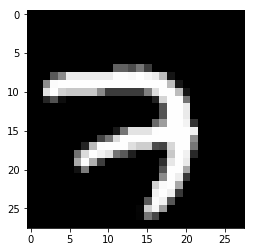

In [39]:
first_image = mnist.train.images[0]
first_image = np.array(first_image, dtype='float32')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [40]:
train_images = []
train_images_labels = []
test_images = []
test_images_labels = []

for i, image in enumerate(mnist.train.images):
    train_images.append(np.array(image, dtype='float32'))
    
for label in mnist.train.labels:
    train_images_labels.append(label)
    
for i, image in enumerate(mnist.test.images):
    test_images.append(np.array(image, dtype='float32'))
    
for label in mnist.test.labels:
    test_images_labels.append(label)
    
print ("Done")
# print (train_images[0])
# print (test_images[0])
# print (train_images_labels[0])
# print (test_images_labels[0])

Done


In [41]:
class TFDeep:
    """
        Class that represents a deep neural network implementation in tensorflow.
    """

    def __init__(self, shapes, param_delta=0.1, param_lambda=0.01, optimizer="gds",
                 activation=tf.nn.relu):
        """Arguments:
           - shapes: shape of neural network
           - C: number of classes
           - param_delta: training step
        """
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, shapes[0]])
        self.Yoh_ = tf.placeholder(dtype=tf.float32, shape=[None, shapes[-1]])
        self.is_training = tf.placeholder(tf.bool)

        self.weights = []
        self.biases = []
        self.hs = []

        for index, shape in enumerate(shapes[1:]):
            self.weights.append(tf.Variable(initial_value=tf.random_normal([shapes[index], shape])))
            self.biases.append(tf.Variable(initial_value=tf.random_normal([1, shape])))

        # NN input
        self.hs.append(activation(self.batch_norm(tf.matmul(self.X, self.weights[0]) + self.biases[0],
                                  self.is_training)))

        # NN inner connections
        for i in range(1, len(shapes[1:-1])):
            self.hs.append(activation(self.batch_norm(tf.matmul(self.hs[-1], self.weights[i]) + self.biases[i],
                                      self.is_training)))

        # NN output
        if len(shapes[1:-1]) == 0:
            # regular logistic regression
            output = tf.matmul(self.X, self.weights[-1]) + self.biases[-1]
        else:
            # neural network last layer output
            output = tf.matmul(self.hs[-1], self.weights[-1]) + self.biases[-1]

        self.probs = tf.nn.softmax(output)

        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.Yoh_ * tf.log(self.probs + 1e-8), axis=1))
        self.regularization = [param_lambda * tf.nn.l2_loss(weights) for weights in self.weights]
        self.loss = self.cross_entropy + tf.add_n(self.regularization)

        if optimizer == "gds":
            self.train_step = tf.train.GradientDescentOptimizer(param_delta).minimize(self.loss)
        elif optimizer == "adam":
            step = tf.Variable(0, trainable=False)
            rate = tf.train.exponential_decay(param_delta, step, 100, 0.98, staircase=True)
            self.train_step = tf.train.AdamOptimizer(rate).minimize(self.loss, global_step=step)

        self.session = tf.Session()
        self.saver = tf.train.Saver()

    def batch_norm(self, inputs, is_training, decay=0.999, epsilon=1e-3):

        scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
        beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
        pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
        pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

        def if_true():
            batch_mean, batch_var = tf.nn.moments(inputs, [0])
            train_mean = tf.assign(pop_mean,
                                   pop_mean * decay + batch_mean * (1 - decay))
            train_var = tf.assign(pop_var,
                                  pop_var * decay + batch_var * (1 - decay))
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                                                 batch_mean, batch_var, beta, scale, epsilon)

        def if_false():
            return tf.nn.batch_normalization(inputs,
                                             pop_mean, pop_var, beta, scale, epsilon)

        result = tf.cond(is_training, if_true, if_false)
        return result

    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        self.session.run(tf.global_variables_initializer())

        for i in range(param_niter+1):
            tr = self.session.run([self.train_step], feed_dict={self.X: X, self.Yoh_: Yoh_})
            if i % 1000 == 0:
                loss = self.session.run(self.loss, feed_dict={self.X: X, self.Yoh_: Yoh_})
                print("{0:4}. Loss: {1:.8f}".format(i, loss))

    def _shuffle(self, X, Yoh_):
        perm = np.random.permutation(len(X))
        return X[perm], Yoh_[perm]

    def _split_dataset(self, X, Yoh_, ratio=0.8):
        X, Yoh_ = self._shuffle(X, Yoh_)
        split = int(ratio * len(X))
        return X[:split], X[split:], Yoh_[:split], Yoh_[split:]

    def train_mb(self, X, Yoh_, n_epochs=1000, batch_size=50, train_ratio=1., print_step=10,
                 model_name=""):
        self.session.run(tf.global_variables_initializer())
        prev_loss = window_loss = float('inf')

        X_train, X_val, Y_train, Y_val = self._split_dataset(X, Yoh_, ratio=train_ratio)
        n_samples = len(X_train)
        n_batches = int(n_samples / batch_size)

        for epoch in range(n_epochs):
            X_train, Y_train = self._shuffle(X_train, Y_train)
            i = 0
            avg_loss = 0

            while i < n_samples:
                batch_X, batch_Yoh_ = X_train[i:i + batch_size], Y_train[i:i + batch_size]
                data_dict = {self.X: batch_X, self.Yoh_: batch_Yoh_, self.is_training: True}
                val_loss, _ = self.session.run([self.loss, self.train_step], feed_dict=data_dict)

                avg_loss += val_loss / n_batches
                i += batch_size

            # validation
            data_dict = {self.X: X_val, self.Yoh_: Y_val, self.is_training: False}
            val_loss, _ = self.session.run([self.loss, self.train_step], feed_dict=data_dict)
            window_loss = min(window_loss, val_loss)
            if epoch % 50 == 0:
                if window_loss > prev_loss:
                    print("Early stopping: epoch", epoch)
                    self.save(epoch, "model_" + str(model_name))
                    # break
                prev_loss = window_loss
                window_loss = float('inf')

            if epoch % print_step == 0:
                print("Epoch: {:4d}; avg_train_loss {:.9f}; validation_loss {:.9f}".format(epoch, avg_loss, val_loss))

        print("Optimization Finished!")
        print("Validation loss {:.9f}".format(val_loss))

    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        probs = self.session.run(self.probs, feed_dict={self.X: X, self.is_training: False})
        return probs

    def classify(self, X):
        return np.argmax(self.eval(X), axis=1)

    def eval_perf(self, Y, Y_):
        # needed to compute scores of our model
        # 'weighted' takes into consideration labels imbalance
        if max(int(max(Y_) + 1), int(max(Y) + 1)) == 2:
            average = 'binary'
        else:
            average = 'weighted'

        accuracy = accuracy_score(Y_, Y)
        precision = precision_score(Y_, Y, average=average)
        recall = recall_score(Y_, Y, average=average)
        f1 = f1_score(Y_, Y, average=average)

        print("Accuracy: {0:.3f}\n"
              "Precision: {1:.3f}\n"
              "Recall: {2:.3f}\n"
              "F1: {3:.3f} ".format(accuracy, precision, recall, f1))

    def save(self, epoch, path_dir):
        if not os.path.exists(path_dir):
            os.makedirs(path_dir)
        epochs = self.saver.save(self.session, path_dir + '/model', global_step=epoch)
        latest = self.saver.save(self.session, path_dir + '/model')
        print("Path for epochs restore: %s" % epochs)
        print("Path for latest restore: %s" % latest)

    def restore(self, path):
        self.saver.restore(self.session, path)
        print("Model restored.")

In [42]:
shape = [784, 10]

tfdeep_gds = TFDeep(shape, param_delta=0.02, param_lambda=0.01, optimizer="gds")
tfdeep_adam = TFDeep(shape, param_delta=0.02, param_lambda=0.01, optimizer="adam")

In [43]:
tfdeep_gds.train_mb(np.array(train_images), np.array(train_images_labels), n_epochs=200,
                    train_ratio=0.8, model_name="784_10_gds")

Epoch:    0; avg_train_loss 38.584992834; validation_loss 29.938133240
Epoch:   10; avg_train_loss 1.435548420; validation_loss 1.289422035
Epoch:   20; avg_train_loss 0.579169182; validation_loss 0.574733913
Epoch:   30; avg_train_loss 0.552267030; validation_loss 0.551084995
Epoch:   40; avg_train_loss 0.550027067; validation_loss 0.548894167
Epoch:   50; avg_train_loss 0.549048776; validation_loss 0.547980666
Epoch:   60; avg_train_loss 0.548790261; validation_loss 0.548041224
Epoch:   70; avg_train_loss 0.548688194; validation_loss 0.547254741
Epoch:   80; avg_train_loss 0.548456507; validation_loss 0.546964407
Epoch:   90; avg_train_loss 0.548285871; validation_loss 0.546542883
Epoch:  100; avg_train_loss 0.548305696; validation_loss 0.547408462
Epoch:  110; avg_train_loss 0.548354626; validation_loss 0.547456980
Epoch:  120; avg_train_loss 0.548390074; validation_loss 0.547211707
Epoch:  130; avg_train_loss 0.548428320; validation_loss 0.546910107
Epoch:  140; avg_train_loss 0.54

In [44]:
tfdeep_adam.train_mb(np.array(train_images), np.array(train_images_labels), n_epochs=200,
                     train_ratio=0.8, model_name="784_10_adam")

Epoch:    0; avg_train_loss 2.754711370; validation_loss 0.671424031
Epoch:   10; avg_train_loss 0.573186990; validation_loss 0.566384256
Epoch:   20; avg_train_loss 0.550130326; validation_loss 0.556915879
Epoch:   30; avg_train_loss 0.545604423; validation_loss 0.553809881
Epoch:   40; avg_train_loss 0.544754894; validation_loss 0.553538322
Epoch:   50; avg_train_loss 0.544561075; validation_loss 0.553533077
Epoch:   60; avg_train_loss 0.544528886; validation_loss 0.553531229
Epoch:   70; avg_train_loss 0.544523205; validation_loss 0.553531289
Epoch:   80; avg_train_loss 0.544522159; validation_loss 0.553531051
Epoch:   90; avg_train_loss 0.544521999; validation_loss 0.553531051
Early stopping: epoch 100
Path for epochs restore: model_784_10_adam/model-100
Path for latest restore: model_784_10_adam/model
Epoch:  100; avg_train_loss 0.544521987; validation_loss 0.553531051
Epoch:  110; avg_train_loss 0.544521989; validation_loss 0.553531110
Epoch:  120; avg_train_loss 0.544521989; val

In [45]:
probs_gds = tfdeep_gds.eval(np.array(test_images))
probs_adam = tfdeep_adam.eval(np.array(test_images))

In [46]:
print("GradientDescentOpt:")
tfdeep_gds.eval_perf(np.argmax(probs_gds, axis=1), np.argmax(test_images_labels, axis=1))

print("\nAdamOpt:")
tfdeep_adam.eval_perf(np.argmax(probs_adam, axis=1), np.argmax(test_images_labels, axis=1))

GradientDescentOpt:
Accuracy: 0.905
Precision: 0.905
Recall: 0.905
F1: 0.905 

AdamOpt:
Accuracy: 0.907
Precision: 0.906
Recall: 0.907
F1: 0.906 


In [47]:
weights_gds = tfdeep_gds.session.run(tfdeep_gds.weights)
weights_adam = tfdeep_adam.session.run(tfdeep_adam.weights)

In [48]:
from matplotlib.colors import LinearSegmentedColormap

W = weights_gds[0].T
W2 = weights_adam[0].T

#cmap
cdict = {'blue':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.1),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'red':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
        }
cmap = LinearSegmentedColormap('BlueRed1', cdict)

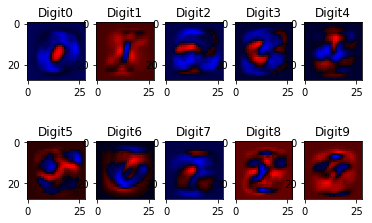

In [49]:
f1, axarr1 = plt.subplots(2, 5)
for i, w in enumerate(W):
    row = 0 if i<5 else 1
    axarr1[row, i%5].set_title('Digit' + str(i))
    axarr1[row, i%5].imshow(w.reshape(28,28),cmap=cmap)
plt.show()

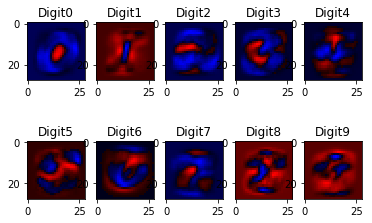

In [50]:
f2, axarr2 = plt.subplots(2, 5)
for i, w in enumerate(W2):
    row = 0 if i<5 else 1
    axarr2[row, i%5].set_title('Digit' + str(i))
    axarr2[row, i%5].imshow(w.reshape(28,28),cmap=cmap)
plt.show()

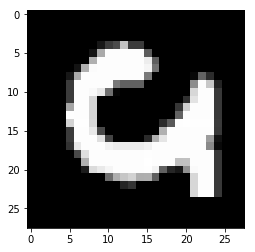

Prob 0.000227411655942
Correct label 9


In [51]:
correct_probs = np.sum(probs_gds * mnist.test.labels, axis=1)
worst_sample = correct_probs.argmin()
plt.imshow(mnist.test.images[worst_sample].reshape(28,28), cmap='gray')
plt.show()

print("Prob", correct_probs[worst_sample])
print("Correct label", mnist.test.labels[worst_sample].argmax())

In [52]:
shape2 = [784, 100, 10]

tfdeep2 = TFDeep(shape2, param_delta=0.015, param_lambda=0.01)

In [53]:
tfdeep2.train_mb(np.array(train_images), np.array(train_images_labels), n_epochs=300,
                 train_ratio=0.8, model_name="784_100_10_adam")

Epoch:    0; avg_train_loss 350.144827028; validation_loss 304.900756836
Epoch:   10; avg_train_loss 25.196731971; validation_loss 22.096340179
Epoch:   20; avg_train_loss 2.113511895; validation_loss 1.912450671
Epoch:   30; avg_train_loss 0.397483401; validation_loss 0.412934303
Epoch:   40; avg_train_loss 0.257439566; validation_loss 0.270605564
Epoch:   50; avg_train_loss 0.230357727; validation_loss 0.251116157
Epoch:   60; avg_train_loss 0.217552060; validation_loss 0.245104089
Epoch:   70; avg_train_loss 0.207835866; validation_loss 0.232757792
Epoch:   80; avg_train_loss 0.200249030; validation_loss 0.227367997
Epoch:   90; avg_train_loss 0.193520696; validation_loss 0.225508064
Epoch:  100; avg_train_loss 0.187503518; validation_loss 0.221059442
Epoch:  110; avg_train_loss 0.182999496; validation_loss 0.212540030
Epoch:  120; avg_train_loss 0.179148669; validation_loss 0.216870353
Epoch:  130; avg_train_loss 0.176880772; validation_loss 0.212952763
Epoch:  140; avg_train_loss 

In [54]:
probs2 = tfdeep2.eval(np.array(test_images))

In [55]:
tfdeep2.eval_perf(np.argmax(probs2, axis=1), np.argmax(test_images_labels, axis=1))

Accuracy: 0.974
Precision: 0.973
Recall: 0.974
F1: 0.973 


In [56]:
shape3 = [784, 100, 100, 10]

tfdeep3 = TFDeep(shape3, param_delta=0.015, param_lambda=0.01)

In [57]:
tfdeep3.train_mb(np.array(train_images), np.array(train_images_labels), n_epochs=300,
                 train_ratio=0.8, model_name="784_100_100_10_adam")

Epoch:    0; avg_train_loss 391.653721965; validation_loss 341.701324463
Epoch:   10; avg_train_loss 28.109571877; validation_loss 24.651517868
Epoch:   20; avg_train_loss 2.223409773; validation_loss 2.010996819
Epoch:   30; avg_train_loss 0.302757584; validation_loss 0.311607003
Epoch:   40; avg_train_loss 0.160947735; validation_loss 0.193401560
Epoch:   50; avg_train_loss 0.142134096; validation_loss 0.186940104
Epoch:   60; avg_train_loss 0.135678912; validation_loss 0.164797932
Epoch:   70; avg_train_loss 0.130375862; validation_loss 0.193169519
Epoch:   80; avg_train_loss 0.125981221; validation_loss 0.164102465
Epoch:   90; avg_train_loss 0.123152170; validation_loss 0.151915371
Epoch:  100; avg_train_loss 0.120774326; validation_loss 0.163910806
Epoch:  110; avg_train_loss 0.121845567; validation_loss 0.154295236
Epoch:  120; avg_train_loss 0.119563474; validation_loss 0.156245530
Epoch:  130; avg_train_loss 0.115343221; validation_loss 0.149925590
Epoch:  140; avg_train_loss 

In [58]:
probs3 = tfdeep3.eval(np.array(test_images))

In [60]:
tfdeep3.eval_perf(np.argmax(probs3, axis=1), np.argmax(test_images_labels, axis=1))

Accuracy: 0.976
Precision: 0.976
Recall: 0.976
F1: 0.976 


In [61]:
shapex = [784, 100, 100, 10]

tfdeep_restored = TFDeep(shapex, param_delta=0.015, param_lambda=0.01)

In [62]:

tfdeep_restored.restore("model_784_100_100_10_adam/model")

INFO:tensorflow:Restoring parameters from model_784_100_100_10_adam/model


NotFoundError: Key Variable_35 not found in checkpoint
	 [[Node: save_4/RestoreV2_29 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_4/Const_0_0, save_4/RestoreV2_29/tensor_names, save_4/RestoreV2_29/shape_and_slices)]]
	 [[Node: save_4/RestoreV2_23/_101 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_216_save_4/RestoreV2_23", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_4/RestoreV2_29', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-e1980205a9de>", line 3, in <module>
    tfdeep_restored = TFDeep(shapex, param_delta=0.015, param_lambda=0.01)
  File "<ipython-input-41-779e395746af>", line 56, in __init__
    self.saver = tf.train.Saver()
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1140, in __init__
    self.build()
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1172, in build
    filename=self._filename)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 688, in build
    restore_sequentially, reshape)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 663, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/dreyus95/Python/tf_environments/tf3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key Variable_35 not found in checkpoint
	 [[Node: save_4/RestoreV2_29 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_4/Const_0_0, save_4/RestoreV2_29/tensor_names, save_4/RestoreV2_29/shape_and_slices)]]
	 [[Node: save_4/RestoreV2_23/_101 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_216_save_4/RestoreV2_23", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
